In [1]:
! pip install mlxtend seaborn --upgrade

In [2]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


# temp 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from collections import defaultdict
from functools import lru_cache
from typing import Dict, List, Optional, Tuple, Union


class AssociationAnalyzer:
    def __init__(self):
        self._initialize_attributes()

    def _initialize_attributes(self):
        """Initialize all class attributes in one place"""
        self.encoded_data = None
        self.rules = None
        self.analysis_results = None
        self.original_data = None
        self.patient_clusters = None
        self.patient_profiles = None
        self.cluster_profiles = None
        self.threshold_experiment_results = None

    @staticmethod
    def _get_categorization_rules() -> Dict[str, Dict]:
        """Define all categorization rules in one place"""
        return {
            "Age_Category": {
                "bins": [0, 30, 60, float("inf")],
                "labels": ["Young", "Middle-aged", "Senior"],
            },
            "BMI_Category": {
                "bins": [0, 18.5, 25, 30, float("inf")],
                "labels": ["Underweight", "Normal", "Overweight", "Obese"],
            },
            "BSA_Category": {
                "bins": [0, 1.5, 1.8, float("inf")],
                "labels": ["Small", "Medium", "Large"],
            },
        }

    def preprocess_data(self, data: pd.DataFrame) -> pd.DataFrame:
        """Optimized preprocessing with vectorized operations"""
        self.original_data = data.copy()
        categorized_data = data.copy()

        # Apply all categorizations using vectorized operations
        cat_rules = self._get_categorization_rules()
        for col, rules in cat_rules.items():
            categorized_data[col] = pd.cut(
                data[col.split("_")[0]],
                bins=rules["bins"],
                labels=rules["labels"],
                right=True,
            )

        # Define columns to encode
        columns_to_encode = [
            "Age_Category",
            "Sex",
            "Smoke",
            "BMI_Category",
            "BSA_Category",
            "occupation_category",
        ] + [
            f"M_{metric}_binned"
            for metric in [
                "20th_quantile",
                "25th_quantile",
                "50th_quantile",
                "75th_quantile",
                "max",
                "mean",
                "median",
                "min",
                "std",
            ]
        ]

        # Vectorized encoding
        self.encoded_data = pd.get_dummies(
            categorized_data[columns_to_encode], prefix=columns_to_encode
        ).astype(bool)

        return self.encoded_data

    @lru_cache(maxsize=32)
    def generate_rules(
        self,
        min_support: float = 0.1,
        min_confidence: float = 0.5,
        min_lift: float = 1.0,
    ) -> pd.DataFrame:
        """Cache-optimized rule generation"""
        frequent_itemsets = apriori(
            self.encoded_data,
            min_support=min_support,
            use_colnames=True,
            low_memory=True,
        )

        self.rules = association_rules(
            frequent_itemsets, metric="confidence", min_threshold=min_confidence
        )
        self.rules = self.rules[self.rules["lift"] >= min_lift]
        return self.rules

    def experiment_with_thresholds(
        self,
        support_thresholds: Optional[List[float]] = None,
        confidence_thresholds: Optional[List[float]] = None,
    ) -> List[Dict]:
        """Optimized threshold experimentation with parallel processing option"""
        support_thresholds = support_thresholds or [0.05, 0.1, 0.15, 0.2, 0.25]
        confidence_thresholds = confidence_thresholds or [0.5, 0.7, 0.75, 0.9]

        results = []

        for support in support_thresholds:
            for confidence in confidence_thresholds:
                rules = self.generate_rules(
                    min_support=support, min_confidence=confidence
                )

                results.append(
                    {
                        "min_support": support,
                        "min_confidence": confidence,
                        "num_rules": len(rules),
                        "avg_lift": rules["lift"].mean() if len(rules) > 0 else 0,
                        "strong_rules": (
                            len(rules[rules["lift"] > 2]) if len(rules) > 0 else 0
                        ),
                        "top_rules": (
                            rules.nlargest(5, "lift")
                            if len(rules) > 0
                            else pd.DataFrame()
                        ),
                    }
                )

        self.threshold_experiment_results = results
        return results

    def cluster_rules(self, n_clusters: Optional[int] = None) -> Dict:
        """Optimized clustering with better feature engineering"""
        feature_matrix = np.column_stack(
            [
                self.rules["support"],
                self.rules["confidence"],
                self.rules["lift"],
                self.rules["antecedents"].apply(len),
                self.rules["consequents"].apply(len),
            ]
        )

        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(feature_matrix)

        if n_clusters is None:
            n_clusters = self._find_optimal_clusters(scaled_features)

        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.rules["Cluster"] = kmeans.fit_predict(scaled_features)

        self.cluster_profiles = self._create_cluster_profiles()
        return self.cluster_profiles

    def cluster_patients(
        self, n_clusters: Optional[int] = None, max_clusters: int = 10
    ) -> Tuple[np.ndarray, Dict]:
        """Optimized patient clustering with improved feature engineering"""
        patient_features = self.create_patient_features_from_rules()

        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(patient_features)

        if n_clusters is None:
            n_clusters = self._find_optimal_clusters(
                scaled_features, max_clusters=max_clusters
            )

        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.patient_clusters = kmeans.fit_predict(scaled_features)
        self.original_data["Cluster"] = self.patient_clusters
        self.patient_profiles = self._create_patient_profiles()

        return self.patient_clusters, self.patient_profiles

    def _find_cluster_rule_patterns(self, cluster_id):
        """
        Find the most common rule patterns in a cluster
        """
        cluster_data = self.encoded_data[self.patient_clusters == cluster_id]
        rule_matches = []

        for _, rule in self.rules.iterrows():
            antecedent_items = list(rule["antecedents"])
            consequent_items = list(rule["consequents"])

            # Check how many patients in cluster match this rule
            matches = (
                cluster_data[antecedent_items].all(axis=1)
                & cluster_data[consequent_items].all(axis=1)
            ).sum()

            if matches > 0:
                rule_matches.append(
                    {
                        "antecedents": antecedent_items,
                        "consequents": consequent_items,
                        "matches": matches,
                        "percentage": matches / len(cluster_data) * 100,
                        "lift": rule["lift"],
                    }
                )

        return sorted(rule_matches, key=lambda x: x["percentage"], reverse=True)[:5]
    
    def _create_patient_profiles(self) -> Dict:
        """Create comprehensive patient profiles efficiently"""
        numerical_cols = ["Age", "Height", "Weight", "BMI", "BSA"]
        categorical_cols = ["Sex", "Smoke", "occupation_category"]
        profiles = {}

        for cluster in np.unique(self.patient_clusters):
            cluster_data = self.original_data[self.original_data["Cluster"] == cluster]

            profiles[cluster] = {
                "size": len(cluster_data),
                "numerical_stats": cluster_data[numerical_cols].agg(
                    ["mean", "std", "min", "max"]
                ),
                "categorical_dist": {
                    col: cluster_data[col].value_counts(normalize=True)
                    for col in categorical_cols
                },
                "common_rules": self._find_cluster_rule_patterns(cluster),
            }

        return profiles


    
    def visualize_results(self) -> None:
        """Unified visualization method"""
        self.visualize_threshold_experiments()
        self.visualize_clusters()
        self.visualize_patient_clusters()

    def print_rule_insights(self):
        """
        Print detailed insights about the rules in a readable format
        """
        insights = self.analyze_rule_insights()

        print("\n=== Association Rule Analysis Insights ===\n")

        print("General Statistics:")
        stats = insights["general_stats"]
        print(f"Total Rules: {stats['total_rules']}")
        print(f"Average Support: {stats['avg_support']:.3f}")
        print(f"Average Confidence: {stats['avg_confidence']:.3f}")
        print(f"Average Lift: {stats['avg_lift']:.3f}")
        print(f"Strong Rules (Lift > 2): {stats['strong_rules']}")

        print("\nTop 5 Most Common Items in Antecedents:")
        for item, count in insights["top_antecedents"].head().items():
            print(f"- {item}: {count}")

        print("\nTop 5 Most Common Items in Consequents:")
        for item, count in insights["top_consequents"].head().items():
            print(f"- {item}: {count}")

        print("\nMetric Distributions:")
        for metric, dist in insights["metric_distributions"].items():
            print(f"\n{metric.capitalize()} Distribution:")
            print(f"Min: {dist['min']:.3f}")
            print(f"Max: {dist['max']:.3f}")
            print(f"Mean: {dist['mean']:.3f}")
            print(f"Std: {dist['std']:.3f}")

        patterns = insights["rule_patterns"]
        print("\nRule Patterns:")
        print(f"Average items in antecedent: {patterns['avg_antecedent_size']:.2f}")
        print(f"Average items in consequent: {patterns['avg_consequent_size']:.2f}")

        print("\nMost Common Item Combinations:")
        for combo, count in patterns["common_combinations"].items():
            print(f"- {combo}: {count}")

    def _analyze_frequent_items(self, column, top_n=10):
        """Analyze most frequent items in antecedents or consequents"""
        items = [item for itemset in self.rules[column] for item in itemset]
        return pd.Series(items).value_counts().head(top_n)

    def _analyze_rule_patterns(self):
        """Analyze patterns in rules structure"""
        return {
            "avg_antecedent_size": self.rules["antecedents"].apply(len).mean(),
            "avg_consequent_size": self.rules["consequents"].apply(len).mean(),
            "common_combinations": self._find_common_combinations(),
        }

    def print_cluster_composition(self):
        """
        Prints a detailed breakdown of which patients are in each cluster
        """
        if not hasattr(self, "patient_cluster_mapping"):
            self.get_patient_cluster_mapping()

        print("\n=== Cluster Composition Analysis ===\n")

        for cluster in sorted(self.patient_cluster_mapping["Cluster"].unique()):
            cluster_patients = self.patient_cluster_mapping[
                self.patient_cluster_mapping["Cluster"] == cluster
            ]

            print(f"\nCluster {cluster}")
            print(f"Number of patients: {len(cluster_patients)}")
            print("Patient IDs:")
            # Print patient IDs in a formatted way, 5 per line
            patient_ids = cluster_patients["Patient_ID"].tolist()
            for i in range(0, len(patient_ids), 5):
                print(", ".join(map(str, patient_ids[i : i + 5])))
            print("-" * 50)

    def save_cluster_assignments(self, filename="patient_clusters.csv"):
        """
        Saves the patient cluster assignments to a CSV file
        """
        if not hasattr(self, "patient_cluster_mapping"):
            self.get_patient_cluster_mapping()

        # Add additional information from original data if available
        full_data = self.patient_cluster_mapping.copy()
        if self.original_data is not None:
            additional_cols = ["Age", "Sex", "BMI", "occupation_category"]
            for col in additional_cols:
                if col in self.original_data.columns:
                    full_data[col] = self.original_data[col].values

        full_data.to_csv(filename, index=False)
        print(f"\nCluster assignments saved to {filename}")

    def _find_common_combinations(self, top_n=5):
        """Find common item combinations in rules"""
        combinations = []
        for _, rule in self.rules.iterrows():
            combinations.append(tuple(sorted(rule["antecedents"])))
            combinations.append(tuple(sorted(rule["consequents"])))
        return pd.Series(combinations).value_counts().head(top_n)

    def print_patient_profiles(self):
        """
        Print detailed profiles for each patient cluster
        """
        if self.patient_profiles is None:
            raise ValueError("Must run cluster_patients() first")

        print("\n=== Patient Cluster Profiles ===\n")

        for cluster_id, profile in self.patient_profiles.items():
            print(f"\nCluster {cluster_id} (Size: {profile['size']} patients)")
            print("-" * 50)

            print("\nNumerical Characteristics:")
            print(profile["numerical_stats"])

            print("\nCategorical Distributions:")
            for cat, dist in profile["categorical_dist"].items():
                print(f"\n{cat}:")
                for val, pct in dist.items():
                    print(f"- {val}: {pct:.1%}")

            print("\nMost Common Rule Patterns:")
            for rule in profile["common_rules"]:
                print(
                    f"\nRule matched by {rule['percentage']:.1f}% of cluster patients:"
                )
                print(f"- Antecedents: {rule['antecedents']}")
                print(f"- Consequents: {rule['consequents']}")
                print(f"- Lift: {rule['lift']:.2f}")

            print("\n" + "=" * 50)

    def get_patient_cluster_mapping(self):
        """
        Creates a DataFrame mapping Patient_IDs to their assigned clusters
        Returns both a DataFrame and saves it to the class instance
        """
        if self.patient_clusters is None:
            raise ValueError("Must run cluster_patients() first")

        # Create mapping DataFrame
        self.patient_cluster_mapping = pd.DataFrame(
            {
                "Patient_ID": self.original_data["Patient_ID"],
                "Cluster": self.patient_clusters,
            }
        )

        # Sort by cluster and then Patient_ID for better readability
        self.patient_cluster_mapping = self.patient_cluster_mapping.sort_values(
            ["Cluster", "Patient_ID"]
        )

        return self.patient_cluster_mapping

    def analyze_rule_insights(self) -> Dict:
        """Generate detailed insights about the rules with improved efficiency"""
        if self.rules is None:
            raise ValueError("Must generate rules first")
            
        insights = {
            "general_stats": {
                "total_rules": len(self.rules),
                "avg_support": self.rules["support"].mean(),
                "avg_confidence": self.rules["confidence"].mean(),
                "avg_lift": self.rules["lift"].mean(),
                "strong_rules": len(self.rules[self.rules["lift"] > 2]),
            },
            "top_antecedents": self._analyze_frequent_items("antecedents"),
            "top_consequents": self._analyze_frequent_items("consequents"),
            "metric_distributions": self._analyze_metric_distributions(),
            "rule_patterns": self._analyze_rule_patterns(),
        }
        return insights

    def _analyze_metric_distributions(self) -> Dict:
        """Analyze metric distributions with improved performance"""
        if self.rules is None:
            raise ValueError("Must generate rules first")
            
        metrics = ["support", "confidence", "lift"]
        return {
            metric: {
                **self.rules[metric].describe().to_dict(),
                "percentiles": self.rules[metric].quantile([0.1, 0.25, 0.5, 0.75, 0.9]).to_dict()
            }
            for metric in metrics
        }

    def analyze_potential_target_items(self) -> pd.DataFrame:
        """Analyzes potential target items with vectorized operations"""
        if self.rules is None:
            raise ValueError("Must generate rules first")

        # Initialize DataFrame for item statistics
        items = pd.DataFrame(index=self.encoded_data.columns)
        
        # Calculate item frequencies in antecedents and consequents
        items["antecedent_count"] = sum(self.rules["antecedents"].apply(
            lambda x: pd.Series(1, index=x)))
        items["consequent_count"] = sum(self.rules["consequents"].apply(
            lambda x: pd.Series(1, index=x)))
        
        # Calculate total appearances
        items["total_count"] = items["antecedent_count"] + items["consequent_count"]
        
        # Calculate average metrics for each item
        def calc_avg_metric(metric: str) -> pd.Series:
            ant_metrics = sum(self.rules.apply(
                lambda row: pd.Series(row[metric], index=row["antecedents"]), axis=1))
            con_metrics = sum(self.rules.apply(
                lambda row: pd.Series(row[metric], index=row["consequents"]), axis=1))
            return (ant_metrics + con_metrics) / items["total_count"]

        items["avg_lift"] = calc_avg_metric("lift")
        items["avg_confidence"] = calc_avg_metric("confidence")
        
        # Calculate max lift
        def calc_max_metric(metric: str) -> pd.Series:
            return pd.concat([
                self.rules.apply(lambda row: pd.Series(row[metric], index=row["antecedents"])),
                self.rules.apply(lambda row: pd.Series(row[metric], index=row["consequents"]))
            ]).max()

        items["max_lift"] = calc_max_metric("lift")
        
        # Calculate interestingness score
        items["interestingness_score"] = (
            items["total_count"] * 0.3 +
            items["avg_lift"] * 0.3 +
            items["avg_confidence"] * 0.2 +
            items["max_lift"] * 0.2
        )
        
        return items.sort_values("interestingness_score", ascending=False)

    def suggest_target_items_for_analysis(
        self, 
        focus: str = "general", 
        top_n: int = 5
    ) -> List[str]:
        """Suggests target items with improved filtering"""
        stats_df = self.analyze_potential_target_items()
        
        focus_filters = {
            "health": lambda x: x.str.contains("BMI_Category|BSA_Category|Smoke"),
            "demographic": lambda x: x.str.contains("Age_Category|Sex|occupation_category"),
            "measurement": lambda x: x.str.contains("M_|A_"),
            "general": lambda x: pd.Series(True, index=x)
        }
        
        if focus not in focus_filters:
            raise ValueError(f"Focus must be one of {list(focus_filters.keys())}")
            
        mask = focus_filters[focus](stats_df.index)
        return stats_df[mask].head(top_n).index.tolist()

    def visualize_threshold_experiments(self) -> None:
        """Enhanced visualization of threshold experiments"""
        if not self.threshold_experiment_results:
            raise ValueError("No threshold experiment results available.")

        # Create DataFrame for visualization
        viz_data = pd.DataFrame([
            {
                "support": r["min_support"],
                "confidence": r["min_confidence"],
                "num_rules": r["num_rules"],
                "avg_lift": r["avg_lift"],
                "strong_rules": r["strong_rules"]
            }
            for r in self.threshold_experiment_results
        ])

        fig = plt.figure(figsize=(15, 12))
        gs = plt.GridSpec(2, 2, figure=fig)
        
        # Heatmaps
        for idx, metric in enumerate(["num_rules", "avg_lift"]):
            ax = fig.add_subplot(gs[0, idx])
            pivot_data = viz_data.pivot(
                index="support", 
                columns="confidence", 
                values=metric
            )
            sns.heatmap(
                pivot_data, 
                annot=True, 
                fmt=".2f" if metric == "avg_lift" else ".0f",
                ax=ax,
                cmap="viridis"
            )
            ax.set_title(f"{metric.replace('_', ' ').title()}")

        # Line plot
        ax = fig.add_subplot(gs[1, 0])
        for conf in sorted(viz_data["confidence"].unique()):
            conf_data = viz_data[viz_data["confidence"] == conf]
            ax.plot(
                conf_data["support"],
                conf_data["num_rules"],
                marker="o",
                label=f"Confidence={conf:.2f}"
            )
        ax.set_xlabel("Support")
        ax.set_ylabel("Number of Rules")
        ax.legend()
        ax.set_title("Rules vs Support by Confidence")

        # Bar plot
        ax = fig.add_subplot(gs[1, 1])
        viz_data.groupby("confidence")["strong_rules"].mean().plot(
            kind="bar",
            ax=ax,
            color="seagreen"
        )
        ax.set_title("Average Strong Rules by Confidence")
        ax.set_xlabel("Confidence")
        ax.set_ylabel("Average Strong Rules")

        plt.tight_layout()
        return fig

    def visualize_clusters(self) -> None:
        """Enhanced visualization of rule clusters"""
        if not hasattr(self, "rules") or "Cluster" not in self.rules.columns:
            raise ValueError("Must run cluster_rules() first")

        fig = plt.figure(figsize=(15, 12))
        gs = plt.GridSpec(2, 2, figure=fig)

        # Support vs Confidence scatter
        ax = fig.add_subplot(gs[0, 0])
        scatter = ax.scatter(
            self.rules["support"],
            self.rules["confidence"],
            c=self.rules["Cluster"],
            cmap="viridis",
            alpha=0.6
        )
        ax.set_xlabel("Support")
        ax.set_ylabel("Confidence")
        ax.set_title("Clusters in Support-Confidence Space")
        plt.colorbar(scatter, ax=ax)

        # Lift distribution
        ax = fig.add_subplot(gs[0, 1])
        sns.boxplot(
            x="Cluster",
            y="lift",
            data=self.rules,
            ax=ax,
            palette="viridis"
        )
        ax.set_title("Lift Distribution by Cluster")

        # Cluster sizes
        ax = fig.add_subplot(gs[1, 0])
        self.rules["Cluster"].value_counts().plot(
            kind="bar",
            ax=ax,
            color=plt.cm.viridis(np.linspace(0, 1, len(self.rules["Cluster"].unique())))
        )
        ax.set_title("Cluster Sizes")

        # Average metrics
        ax = fig.add_subplot(gs[1, 1])
        metrics = self.rules.groupby("Cluster")[["support", "confidence", "lift"]].mean()
        metrics.plot(kind="bar", ax=ax)
        ax.set_title("Average Metrics by Cluster")
        ax.legend(bbox_to_anchor=(1.05, 1))

        plt.tight_layout()
        return fig

    def visualize_patient_clusters(self) -> None:
        """Enhanced visualization of patient clusters"""
        if self.patient_clusters is None:
            raise ValueError("Must run cluster_patients() first")

        fig = plt.figure(figsize=(20, 12))
        gs = plt.GridSpec(2, 3, figure=fig)

        # Age distribution
        ax = fig.add_subplot(gs[0, 0])
        sns.boxplot(
            x="Cluster",
            y="Age",
            data=self.original_data,
            ax=ax,
            palette="viridis"
        )
        ax.set_title("Age Distribution by Cluster")

        # BMI distribution
        ax = fig.add_subplot(gs[0, 1])
        sns.boxplot(
            x="Cluster",
            y="BMI",
            data=self.original_data,
            ax=ax,
            palette="viridis"
        )
        ax.set_title("BMI Distribution by Cluster")

        # Cluster sizes
        ax = fig.add_subplot(gs[0, 2])
        self.original_data["Cluster"].value_counts().plot(
            kind="bar",
            ax=ax,
            color=plt.cm.viridis(np.linspace(0, 1, len(np.unique(self.patient_clusters))))
        )
        ax.set_title("Cluster Sizes")

        # Categorical distributions
        for idx, col in enumerate(["occupation_category", "Smoke"]):
            ax = fig.add_subplot(gs[1, idx])
            pd.crosstab(
                self.original_data["Cluster"],
                self.original_data[col],
                normalize="index"
            ).plot(
                kind="bar",
                stacked=True,
                ax=ax
            )
            ax.set_title(f"{col.replace('_', ' ').title()} by Cluster")
            ax.legend(bbox_to_anchor=(1.05, 1))

        plt.tight_layout()
        return fig

    def analyze_rule_metrics_distribution(self) -> Dict:
        """Analyze rule metrics with improved statistical analysis"""
        if self.rules is None:
            raise ValueError("Must generate rules first")

        metrics = ["support", "confidence", "lift"]
        percentiles = [10, 25, 50, 75, 90]
        
        stats = {}
        for metric in metrics:
            series = self.rules[metric]
            stats[metric] = {
                **series.describe().to_dict(),
                "percentiles": series.quantile(
                    [p/100 for p in percentiles]
                ).to_dict()
            }

        # Calculate suggested thresholds
        suggested_thresholds = {
            "conservative": {
                metric: stats[metric]["percentiles"][0.75]
                for metric in metrics
            },
            "balanced": {
                metric: stats[metric]["percentiles"][0.5]
                for metric in metrics
            },
            "aggressive": {
                metric: stats[metric]["percentiles"][0.25]
                for metric in metrics
            }
        }

        # Visualize distributions
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("Distribution of Rule Metrics")

        for idx, metric in enumerate(metrics):
            sns.histplot(data=self.rules, x=metric, kde=True, ax=axes[idx])
            for profile, thresholds in suggested_thresholds.items():
                axes[idx].axvline(
                    thresholds[metric],
                    color={"conservative": "r", "balanced": "g", "aggressive": "b"}[profile],
                    linestyle="--",
                    label=profile.title()
                )
            axes[idx].set_title(f"{metric.title()} Distribution")
            axes[idx].legend()

        plt.tight_layout()
        
        return {
            "stats": stats,
            "suggested_thresholds": suggested_thresholds
        }

    def _find_optimal_clusters(self, features, max_clusters=10):
        """Find optimal number of clusters using silhouette score"""
        silhouette_scores = []

        for k in range(2, max_clusters + 1):
            kmeans = KMeans(n_clusters=k, random_state=42)
            clusters = kmeans.fit_predict(features)
            score = silhouette_score(features, clusters)
            silhouette_scores.append(score)

        return np.argmax(silhouette_scores) + 2

    def _create_cluster_profiles(self):
        """Create detailed profiles for each cluster"""
        profiles = {}

        for cluster in self.rules["Cluster"].unique():
            cluster_rules = self.rules[self.rules["Cluster"] == cluster]

            profiles[cluster] = {
                "size": len(cluster_rules),
                "avg_metrics": {
                    "support": cluster_rules["support"].mean(),
                    "confidence": cluster_rules["confidence"].mean(),
                    "lift": cluster_rules["lift"].mean(),
                },
                "top_rules": cluster_rules.nlargest(5, "lift"),
                "common_items": self._get_common_items(cluster_rules),
            }

        return profiles

    def _get_common_items(self, rules):
        """Find common items in a set of rules"""
        all_items = []
        for _, rule in rules.iterrows():
            all_items.extend(rule["antecedents"])
            all_items.extend(rule["consequents"])
        return pd.Series(all_items).value_counts().head(5)

    def create_patient_features_from_rules(self):
        """
        Create patient features based on how well they match the discovered association rules.
        Optimized version that prevents DataFrame fragmentation.
        """
        if self.rules is None or self.encoded_data is None:
            raise ValueError("Must generate rules before creating patient features")

        # Initialize list to store feature Series
        feature_series_list = []
        feature_names = []

        # Create all features at once
        for idx, rule in self.rules.iterrows():
            antecedent_items = list(rule["antecedents"])
            consequent_items = list(rule["consequents"])

            # Check if patient matches antecedent and consequent
            antecedent_match = self.encoded_data[antecedent_items].all(axis=1)
            consequent_match = self.encoded_data[consequent_items].all(axis=1)

            # Create feature name
            feature_name = f"rule_{idx}_match"
            feature_names.append(feature_name)

            # Create feature series with rule matching and lift weight
            feature_series = (antecedent_match & consequent_match).astype(float) * rule[
                "lift"
            ]
            feature_series_list.append(feature_series)

        # Combine all features at once using concat
        patient_features = pd.concat(feature_series_list, axis=1)
        patient_features.columns = feature_names

        return patient_features

# Example usage remains the same but with improved efficiency
# if __name__ == "__main__":
#     analyzer = AssociationAnalyzer()
#     data = pd.read_csv("data/translated_new_binned_DropNaN.csv")
#     analyzer.preprocess_data(data)
#     analyzer.generate_rules()
#     analyzer.experiment_with_thresholds()
#     analyzer.visualize_results()



/tmp/ipykernel_2118/1186345607.py:607: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_2118/1186345607.py:645: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_2118/1186345607.py:656: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(



=== Cluster Composition Analysis ===


Cluster 0
Number of patients: 19
Patient IDs:
SB-009, SB-012, SB-021, SB-022, SB-036
SB-039, SB-042, SB-049, SB-053, SB-063
SB-075, SB-078, SB-080, SB-088, SB-093
SB-095, SB-099, SB-118, SB-119
--------------------------------------------------

Cluster 1
Number of patients: 51
Patient IDs:
SB-003, SB-006, SB-008, SB-010, SB-011
SB-014, SB-016, SB-017, SB-018, SB-020
SB-024, SB-025, SB-028, SB-029, SB-031
SB-032, SB-033, SB-035, SB-037, SB-043
SB-047, SB-048, SB-054, SB-056, SB-058
SB-059, SB-060, SB-061, SB-062, SB-064
SB-066, SB-068, SB-070, SB-071, SB-072
SB-073, SB-077, SB-079, SB-082, SB-083
SB-084, SB-086, SB-089, SB-091, SB-101
SB-108, SB-111, SB-115, SB-117, SB-121
SB-122
--------------------------------------------------

Cluster 2
Number of patients: 5
Patient IDs:
SB-001, SB-004, SB-007, SB-081, SB-085
--------------------------------------------------

Cluster 3
Number of patients: 8
Patient IDs:
SB-023, SB-026, SB-044, SB-046, SB-050

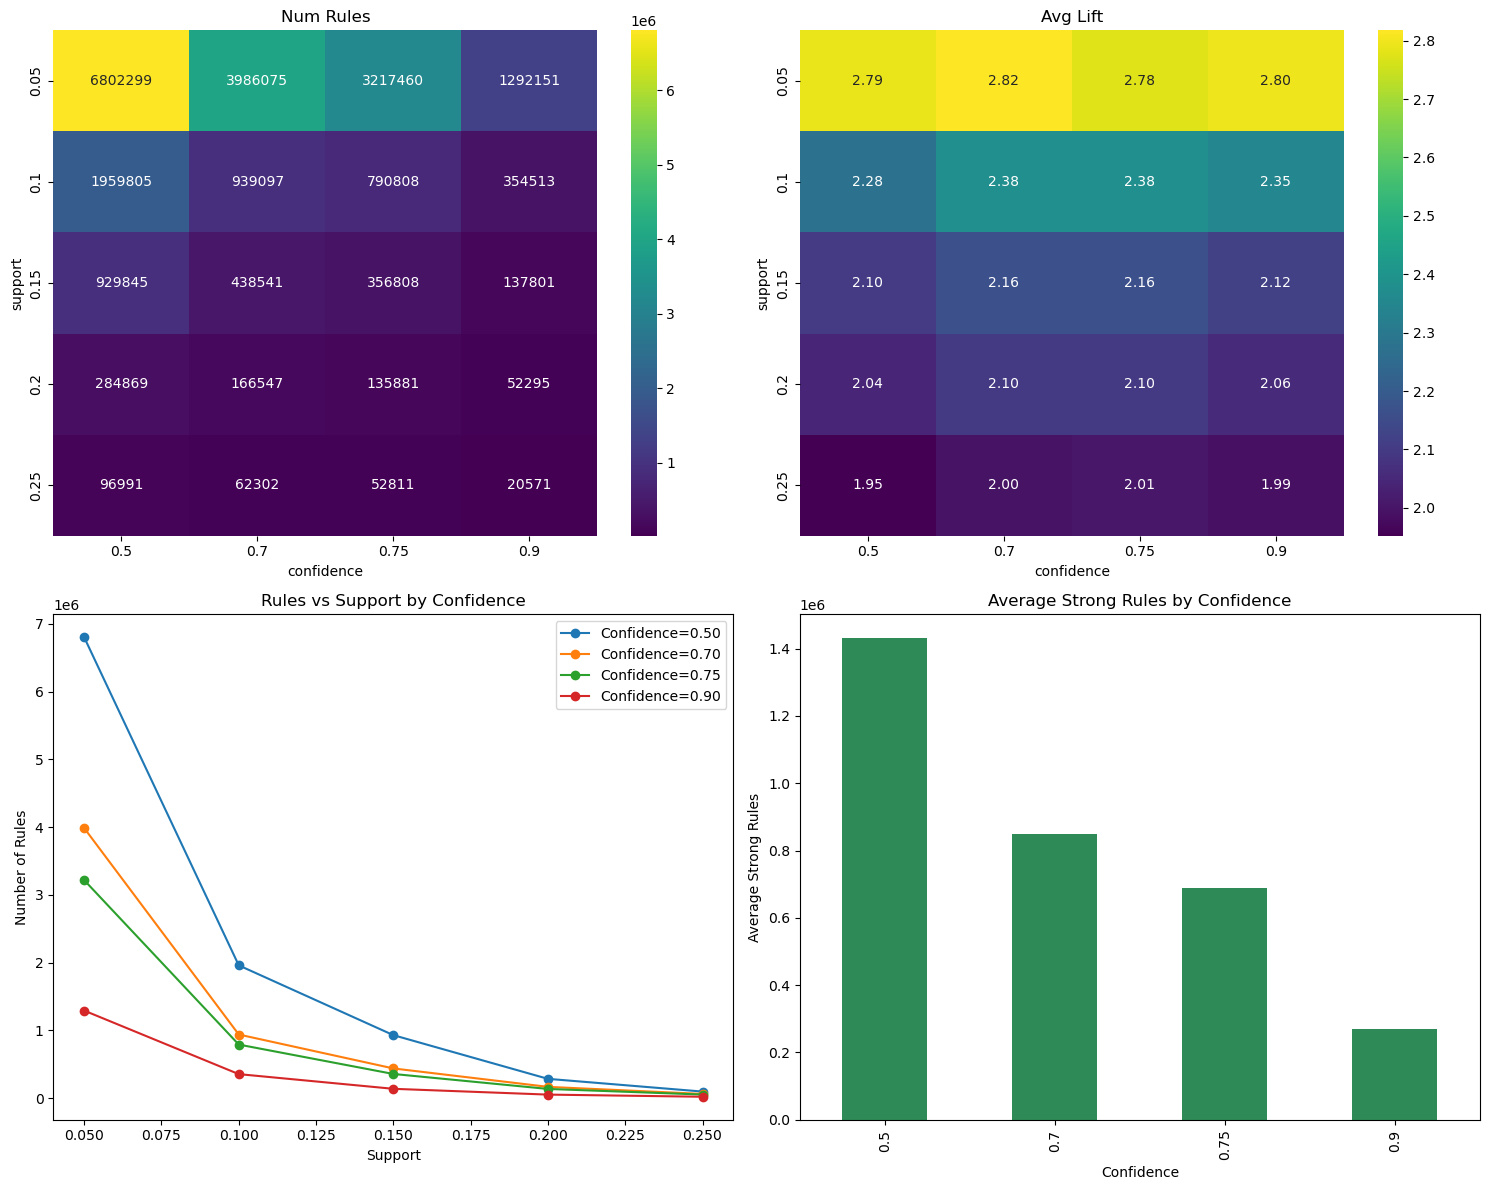

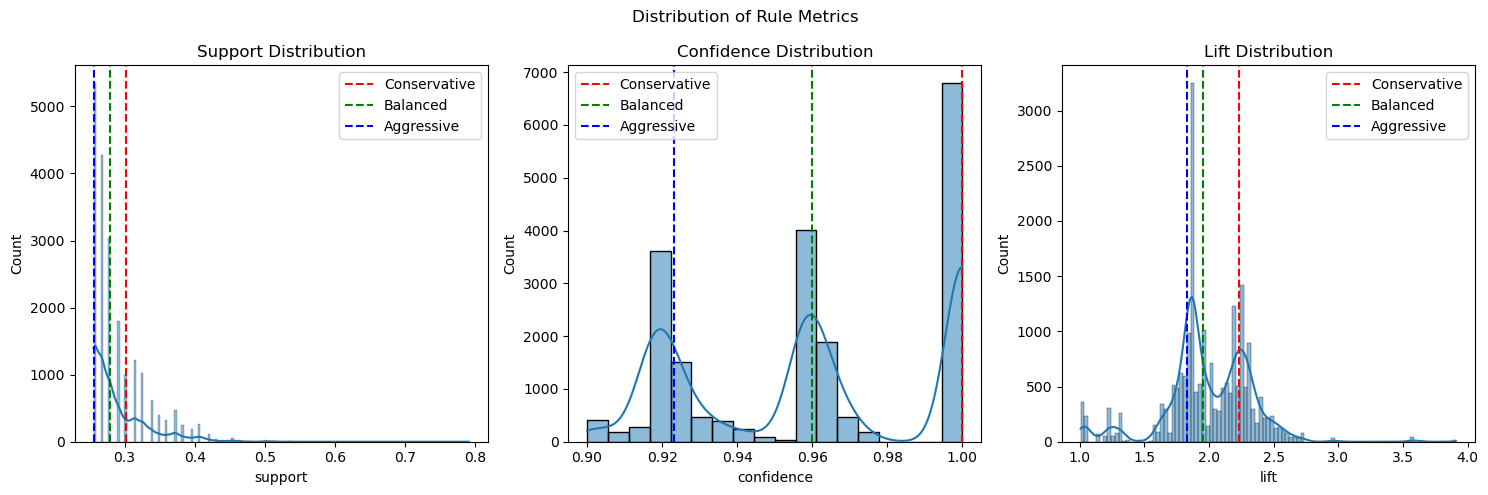

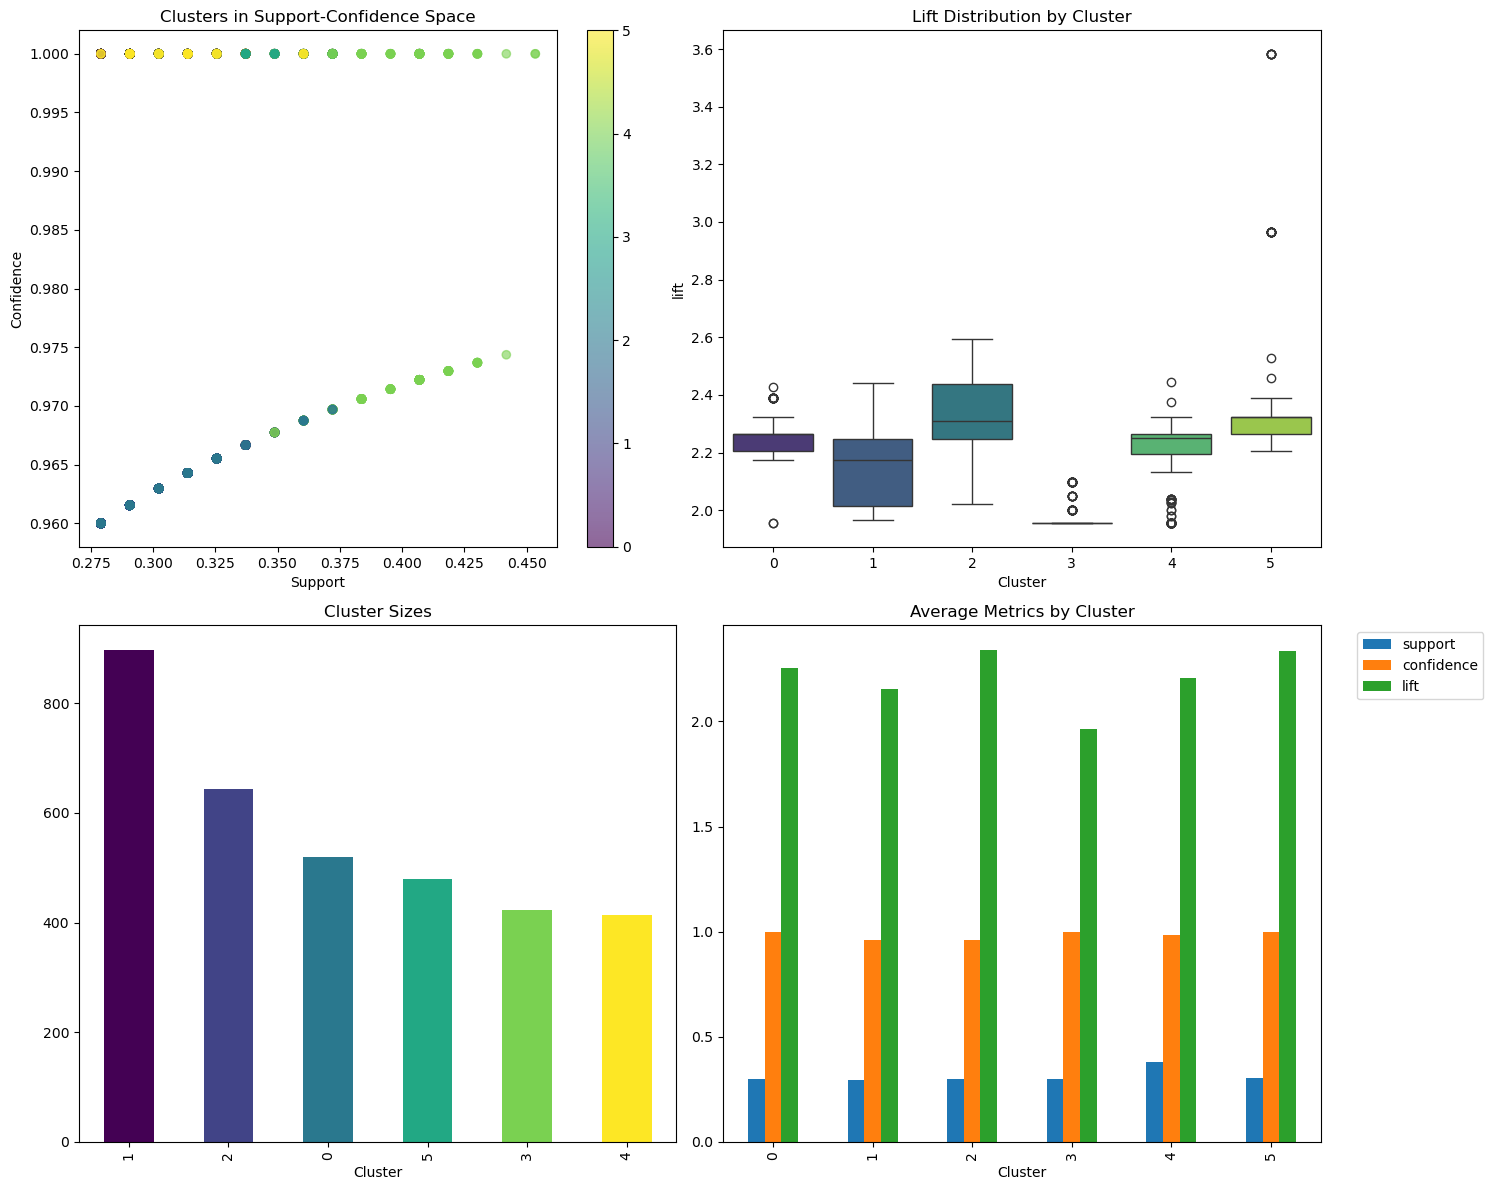

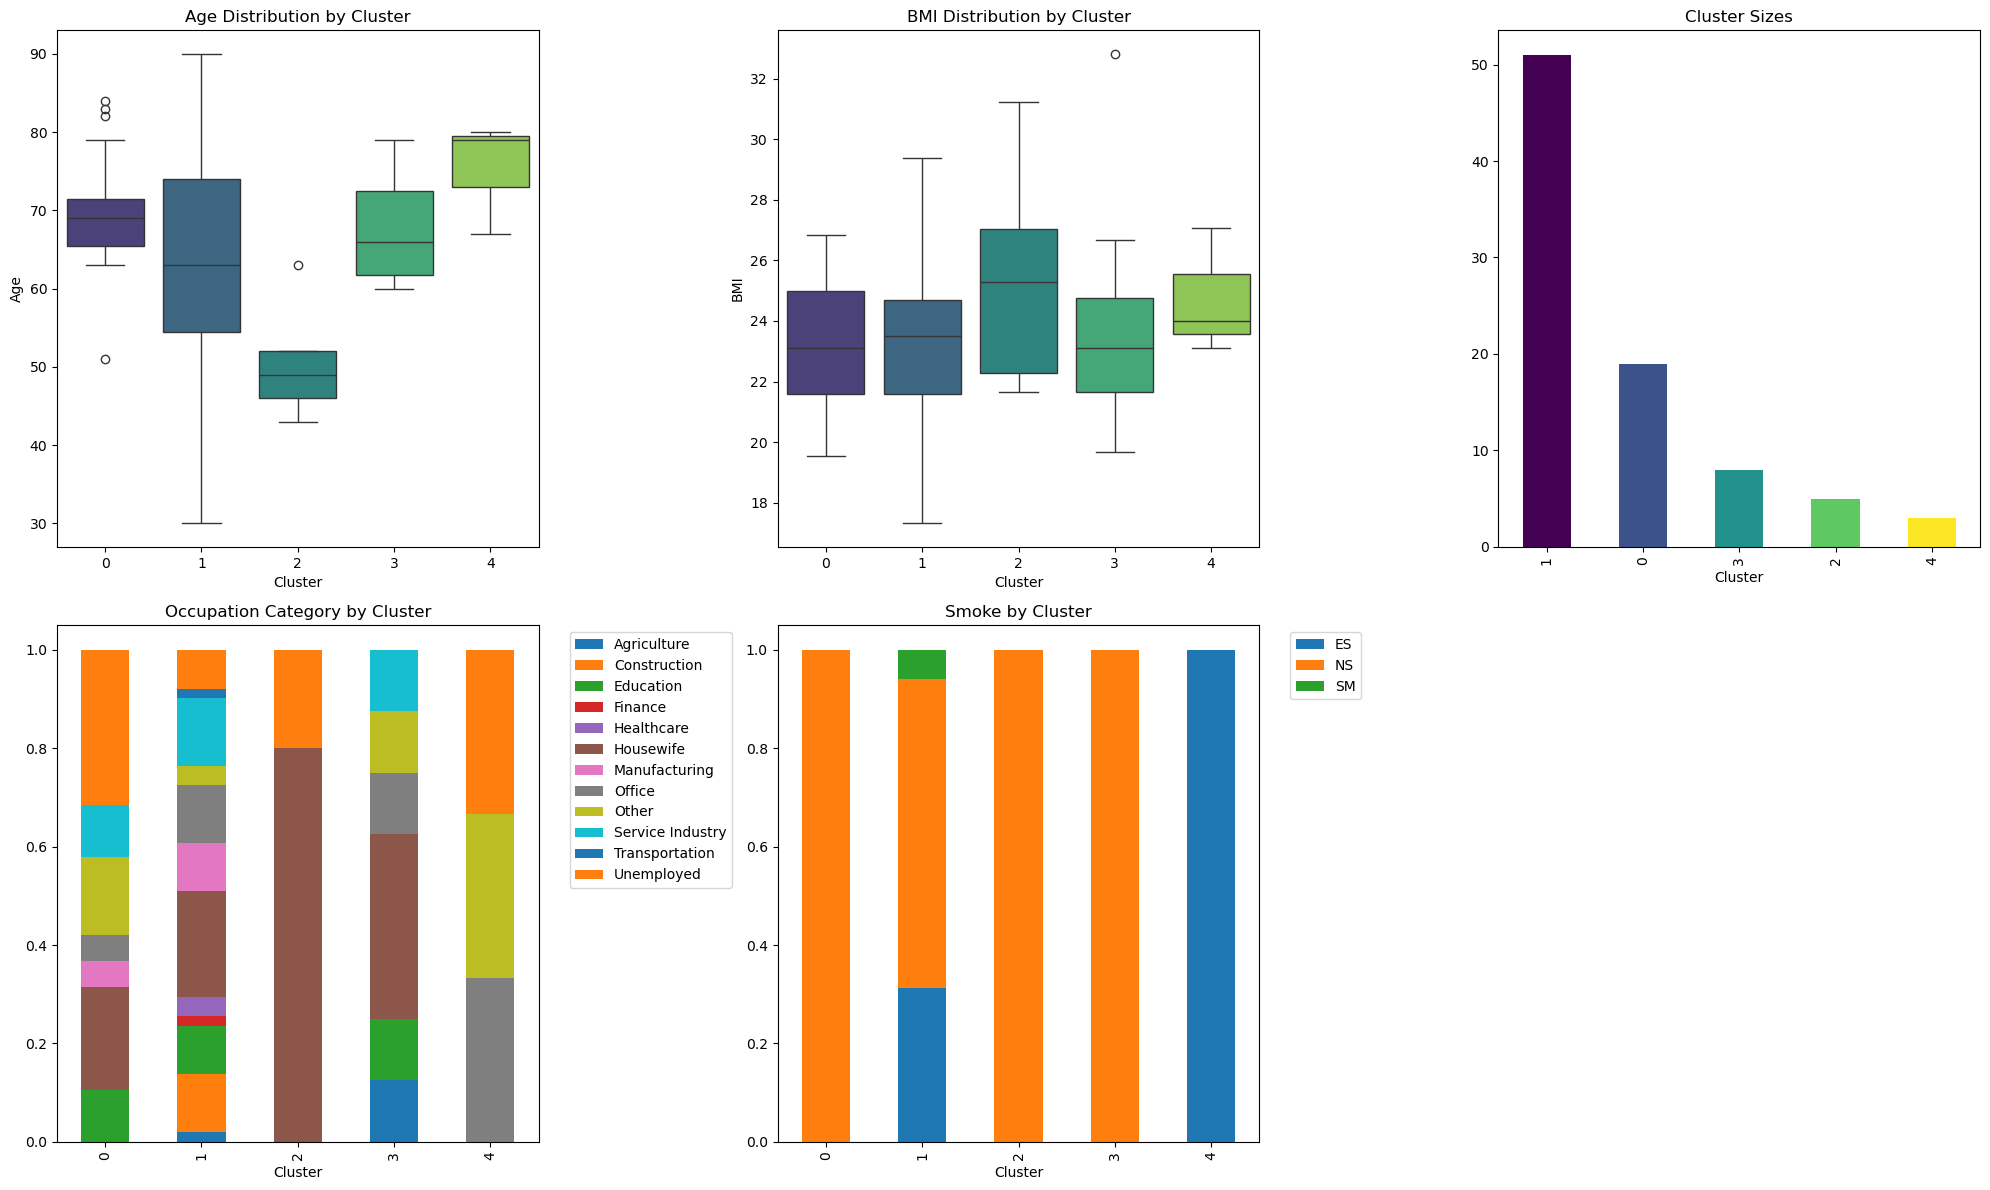

In [4]:

def run_complete_analysis(data_path):
    # Initialize analyzer
    analyzer = AssociationAnalyzer()
    
    # 1. Load and preprocess data
    data = pd.read_csv(data_path)
    analyzer.preprocess_data(data)
    
    # 2. Experiment with thresholds
    analyzer.experiment_with_thresholds()
    analyzer.visualize_threshold_experiments()
    
    # 3. Find best parameters
    metrics_analysis = analyzer.analyze_rule_metrics_distribution()
    best_params = metrics_analysis['suggested_thresholds']['balanced']
    
    # 4. Generate rules with best parameters
    rules = analyzer.generate_rules(
        min_support=best_params['support'],
        min_confidence=best_params['confidence'],
        min_lift=best_params['lift']
    )
    
    # 5. Cluster rules
    analyzer.cluster_rules()
    analyzer.visualize_clusters()
    
    # 6. Create patient clusters
    analyzer.cluster_patients()
    analyzer.visualize_patient_clusters()
    
    # 7. Get patient cluster assignments
    patient_mapping = analyzer.get_patient_cluster_mapping()
    analyzer.print_cluster_composition()
    analyzer.print_patient_profiles()
    
    # 8. Save results
    analyzer.save_cluster_assignments("patient_clusters.csv")
    
    return analyzer

# Usage
analyzer = run_complete_analysis("data/translated_new_binned_DropNaN.csv")